In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([0.00319858, 0.002784  , 0.04810512, 0.03201213], dtype=float32)

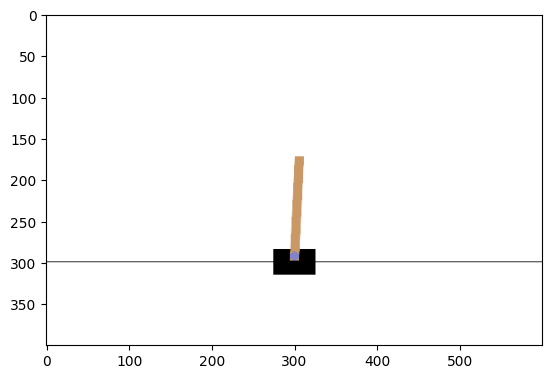

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#测试游戏环境
def test_env():
    state = env.reset()
    print('这个游戏的状态用4个数字表示,我也不知道这4个数字分别是什么意思,反正这4个数字就能描述游戏全部的状态')
    print('state=', state)
    #state= [ 0.03490619  0.04873464  0.04908862 -0.00375859]

    print('这个游戏一共有2个动作,不是0就是1')
    print('env.action_space=', env.action_space)
    #env.action_space= Discrete(2)

    print('随机一个动作')
    action = env.action_space.sample()
    print('action=', action)
    #action= 1

    print('执行一个动作,得到下一个状态,奖励,是否结束')
    state, reward, over, _ = env.step(action)

    print('state=', state)
    #state= [ 0.02018229 -0.16441101  0.01547085  0.2661691 ]

    print('reward=', reward)
    #reward= 1.0

    print('over=', over)
    #over= False


test_env()

这个游戏的状态用4个数字表示,我也不知道这4个数字分别是什么意思,反正这4个数字就能描述游戏全部的状态
state= [-0.00165764  0.02087691  0.017921    0.02388013]
这个游戏一共有2个动作,不是0就是1
env.action_space= Discrete(2)
随机一个动作
action= 0
执行一个动作,得到下一个状态,奖励,是否结束
state= [-0.00124011 -0.1744974   0.0183986   0.32216302]
reward= 1.0
over= False


In [4]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=2, bias=True)
)

In [5]:
import random


#得到一个动作
def get_action(state):
    if random.random() < 0.01:
        return random.choice([0, 1])

    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 4)

    return model(state).argmax().item()


get_action([0.0013847, -0.01194451, 0.04260966, 0.00688801])

0

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action)

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((208, 0), 208)

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples])
    #[b]
    action = torch.LongTensor([i[1] for i in samples])
    #[b]
    reward = torch.FloatTensor([i[2] for i in samples])
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples])
    #[b]
    over = torch.LongTensor([i[4] for i in samples])

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action, reward, next_state[:5], over

/tmp/ipykernel_1222/1396937354.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples])


(tensor([[-0.0025, -0.9491,  0.0061,  1.3563],
         [-0.1198, -1.3959,  0.1745,  2.2377],
         [ 0.0128, -0.1778,  0.0111,  0.3327],
         [-0.0972, -1.1807,  0.0682,  1.7701],
         [-0.0101, -0.1841,  0.0268,  0.2873]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([[-0.0214, -1.1443,  0.0332,  1.6509],
         [-0.1477, -1.5922,  0.2193,  2.5787],
         [ 0.0092, -0.3731,  0.0177,  0.6289],
         [-0.1208, -1.3765,  0.1036,  2.0831],
         [-0.0138, -0.3796,  0.0325,  0.5883]]),
 tensor([0,

In [8]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 4] -> [b, 2]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 2] -> [b]
    value = value[range(64), action]

    return value


get_value(state, action)

tensor([-0.1012, -0.2599,  0.0318, -0.1834,  0.0314,  0.0534,  0.0356, -0.0098,
         0.0410,  0.0453, -0.2864, -0.1689, -0.0071,  0.0648, -0.1902, -0.2391,
         0.0651, -0.2211,  0.0381, -0.1216, -0.1402, -0.1801,  0.0347, -0.2975,
         0.0560,  0.0296, -0.2869, -0.1836, -0.2856, -0.1368, -0.0393, -0.3343,
        -0.1197, -0.2345, -0.0319, -0.0046, -0.2700,  0.0633, -0.0794, -0.2334,
        -0.2527,  0.0007, -0.2348, -0.0353,  0.0057, -0.2295,  0.0348, -0.0424,
        -0.2762, -0.0709, -0.0013,  0.0605,  0.0303, -0.1931,  0.0486,  0.0197,
        -0.2239, -0.0374, -0.2874,  0.0325, -0.0511,  0.0595, -0.1365, -0.3406],
       grad_fn=<IndexBackward0>)

In [9]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 4] -> [b, 2]
    with torch.no_grad():
        target = model(next_state)

    #取所有动作中分数最大的
    #[b, 2] -> [b]
    target = target.max(dim=1)[0]

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b]
    for i in range(64):
        if over[i]:
            target[i] = 0

    #下一个状态的分数乘以一个系数,相当于权重
    #[b] * [b] -> [b]
    target *= 0.98

    #加上reward就是最终的分数
    #[b] + [b] -> [b]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([0.8519, 1.0000, 0.9941, 0.7699, 0.9947, 1.0274, 1.0034, 0.9538, 1.0023,
        1.0193, 0.6662, 0.7861, 0.9602, 1.0340, 0.7604, 0.7128, 1.0369, 0.7331,
        1.0056, 0.8307, 0.8136, 0.7718, 1.0042, 1.0000, 1.0290, 0.9952, 1.0000,
        0.7701, 1.0000, 0.8163, 0.9235, 1.0000, 0.8340, 0.7184, 0.9374, 0.9615,
        0.6846, 1.0348, 0.8688, 0.7189, 0.7010, 0.9654, 0.7193, 0.9292, 0.9687,
        0.7251, 0.9983, 0.9201, 0.6763, 0.8743, 0.9652, 1.0339, 0.9904, 0.7586,
        1.0215, 0.9773, 0.7299, 0.9267, 0.6667, 0.9952, 0.9065, 1.0338, 0.8174,
        1.0000])

In [10]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play:
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

10.0

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(500):
        #更新N条数据
        update_count, drop_count = update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 411 203 0 9.25
50 10000 394 394 179.55
100 10000 200 200 200.0
150 10000 200 200 199.15
200 10000 200 200 190.3
250 10000 200 200 198.45
300 10000 344 344 184.95
350 10000 200 200 200.0
400 10000 200 200 200.0
450 10000 200 200 198.3


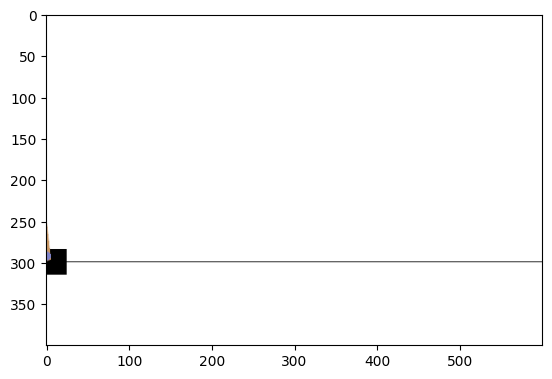

200.0

In [12]:
test(play=True)